# RSICD Baseline — Naive Bayes


This notebook trains a **Naive Bayes (one-vs-rest)** baseline for **Image Captioning on the RSICD dataset** using your **preprocessed** files.

It will:
1) Install required packages inside the notebook
2) Load preprocessed data from `./data/`
3) Build bag-of-words targets (counts for Ridge, binary for NB)
4) Train the model and generate captions for **all validation images**
5) Compute and save metrics: **BLEU-1, BLEU-4, METEOR, Precision, Recall, F1**, and **CIDEr** (if available)
6) Save predictions to `results_nb.json` and metrics to `eval_nb.csv`

> If your notebook is inside the project root `image-captioning-rsicd/`, keep `data_dir = './data'`.


In [1]:
# 📦 Environment setup
# 📦 Environment setup
import sys
!{sys.executable} -m pip install scikit-learn nltk git+https://github.com/salaniz/pycocoevalcap

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

  Cloning https://github.com/salaniz/pycocoevalcap to /private/var/folders/7c/gc219jh128z212hgnr3nv89m0000gn/T/pip-req-build-b9rq0w05
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /private/var/folders/7c/gc219jh128z212hgnr3nv89m0000gn/T/pip-req-build-b9rq0w05
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package wordnet to /Users/angel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [85]:
import os, json, random, collections, csv
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Model import
from sklearn.naive_bayes import GaussianNB

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
try:
    from nltk.translate.meteor_score import meteor_score
    _HAVE_METEOR = True
except Exception as _e:
    print("NLTK METEOR not available:", _e)
    _HAVE_METEOR = False

try:
    if '_HAVE_CIDER' in globals() and _HAVE_CIDER:
        from pycocoevalcap.cider.cider import Cider
    else:
        Cider = None
except Exception as _e:
    print("pycocoevalcap not available:", _e)
    Cider = None

data_dir = "./data"  # change if needed
vocab_limit = 400
min_count = 1
decode_len = 5
random_seed = 42
np.random.seed(random_seed); random.seed(random_seed)

SPECIAL_STR = ["<pad>", "<start>", "<end>", "<unk>"]

In [73]:
def load_json(p):
    with open(p, "r") as f:
        return json.load(f)

def load_data(data_dir):
    caps_tok = load_json(os.path.join(data_dir, "captions_tokens.json"))
    word_to_idx = load_json(os.path.join(data_dir, "word_to_idx.json"))
    idx_to_word = load_json(os.path.join(data_dir, "idx_to_word.json"))
    img_map = load_json(os.path.join(data_dir, "image_map.json"))
    train_list = load_json(os.path.join(data_dir, "train.json"))
    val_list = load_json(os.path.join(data_dir, "val.json"))
    test_list = load_json(os.path.join(data_dir, "test.json"))
    feats = np.load(os.path.join(data_dir, "image_features.npy"))
    return caps_tok, word_to_idx, idx_to_word, img_map, train_list, val_list, test_list, feats

caps_tok, word_to_idx, idx_to_word, img_map, train_list, val_list, test_list, feats = load_data(data_dir)
idx_to_word = {int(k): v for k, v in idx_to_word.items()}

In [74]:
def refs_for_image(caps_dict, idx_to_word, img_name):
    entries = caps_dict.get(img_name, [])
    out = []
    for cap in entries:
        if len(cap) == 0:
            continue
        if isinstance(cap[0], int) or (isinstance(cap[0], str) and cap[0].isdigit()):
            words = []
            for tok in cap:
                try:
                    tid = int(tok)
                    w = idx_to_word.get(tid, "<unk>")
                except:
                    w = str(tok)
                if w not in SPECIAL_STR:
                    words.append(w)
            out.append(words)
        else:
            words = [w for w in cap if w not in SPECIAL_STR]
            out.append(words)
    return out

def build_vocab(train_imgs, caps_tok, topk=vocab_limit, min_count=min_count):
    cnt = collections.Counter()
    for img in train_imgs:
        for ref in caps_tok.get(img, []):
            if len(ref)==0:
                continue
            if isinstance(ref[0], int) or (isinstance(ref[0], str) and ref[0].isdigit()):
                words = []
                for tok in ref:
                    try:
                        tid = int(tok)
                        w = idx_to_word.get(tid, "<unk>")
                    except:
                        w = str(tok)
                    words.append(w)
            else:
                words = ref
            for w in words:
                if w not in SPECIAL_STR:
                    cnt[w]+=1
    items = [(w,c) for w,c in cnt.items() if c>=min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    words = [w for w,_ in items[:topk]]
    w2i = {w:i for i,w in enumerate(words)}
    i2w = {i:w for w,i in w2i.items()}
    return w2i, i2w

w2i, i2w = build_vocab(train_list, caps_tok, vocab_limit, min_count)
V = len(w2i)
D = feats.shape[1]
print(f"Features: shape={feats.shape} | Vocab size: {V} | Using model: NaiveBayes")

Features: shape=(10921, 2048) | Vocab size: 400 | Using model: NaiveBayes


In [75]:
def build_targets(img_list, binary=False):
    X, Y, names = [], [], []
    for img in img_list:
        if img not in img_map: 
            continue
        idx = img_map[img]
        if idx is None or idx>=len(feats):
            continue
        X.append(feats[idx])
        names.append(img)
        vec = np.zeros(V, dtype=float)
        for ref in caps_tok.get(img, []):
            if len(ref)==0:
                continue
            if isinstance(ref[0], int) or (isinstance(ref[0], str) and ref[0].isdigit()):
                words = []
                for tok in ref:
                    try:
                        tid = int(tok); w = idx_to_word.get(tid, "<unk>")
                    except:
                        w = str(tok)
                    words.append(w)
            else:
                words = ref
            for w in words:
                if w in w2i: vec[w2i[w]] += 1.0
        if binary: vec = (vec > 0).astype(float)
        Y.append(vec)
    if len(X)==0:
        raise RuntimeError("No images matched features mapping. Check data paths and image_map.json.")
    return np.asarray(X, dtype=float), np.vstack(Y), names

X_tr, Y_tr, names_tr = build_targets(train_list, binary=True)
X_va, Y_va, names_va = build_targets(val_list,   binary=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_tr = scaler.fit_transform(X_tr)
X_va = scaler.transform(X_va)

In [76]:
def train_model(X, Y):
    model = [GaussianNB() for _ in range(V)]
    for j in range(V):
        if j % 200 == 0:
            print(f'Training NB classifier {j}/{V}...')
        model[j].fit(X, Y[:, j])
    return model

In [77]:
def predict_scores(model, X):
    if "nb" == "ridge":
        scores = model.predict(X)
        scores = np.maximum(scores, 0.0)
        mx = scores.max(axis=1, keepdims=True) + 1e-8
        scores = scores / mx
        return scores
    else:
        N = X.shape[0]
        out = np.zeros((N, V), dtype=float)
        for j in range(V):
            if hasattr(model[j], "predict_proba"):
                proba = model[j].predict_proba(X)
                if proba.shape[1] == 2:
                    out[:, j] = proba[:, 1]
                else:
                    out[:, j] = 0.0
            else:
                out[:, j] = 0.5
        return out

In [78]:
# ===== Train model =====
model = train_model(X_tr, Y_tr)

# ===== Validation predictions =====
scores_va = predict_scores(model, X_va)

# Convert validation scores to top-k binary predictions
def topk_to_binary(scores, k):
    N, V = scores.shape
    Y_pred = np.zeros((N, V), dtype=int)
    for i in range(N):
        idxs = np.argsort(-scores[i])[:k]
        Y_pred[i, idxs] = 1
    return Y_pred

Y_pred_val = topk_to_binary(scores_va, k=decode_len)

# ===== Build and scale test set =====
X_te, Y_te, names_te = build_targets(test_list, binary=True)
X_te = scaler.transform(X_te)

# Predict and convert to top-k binary on test set
scores_te = predict_scores(model, X_te)
Y_pred_test = topk_to_binary(scores_te, k=decode_len)

# ===== Define for metrics =====
y_test = Y_te
y_pred_test = Y_pred_test


Training NB classifier 0/400...
Training NB classifier 200/400...


In [79]:
def decode_from_scores(scores, k=decode_len):
    caps = []
    for i in range(scores.shape[0]):
        idxs = np.argsort(-scores[i])[:k]
        words = [i2w[j] for j in idxs if i2w[j] not in SPECIAL_STR]
        caps.append(" ".join(words))
    return caps

pred_caps = decode_from_scores(scores_va, k=decode_len)

In [80]:
def as_corpus_references(img_names):
    return [refs_for_image(caps_tok, idx_to_word, nm) for nm in img_names]

def tokenize_caption(s):
    return [w for w in s.strip().split() if len(w) > 0]

# ===== Build reference and hypothesis sets =====
refs_corpus = as_corpus_references(names_va)
hyps_tokens = [tokenize_caption(s) for s in pred_caps]

# ===== BLEU Evaluation =====
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smoothie = SmoothingFunction().method3

bleu1 = corpus_bleu([[r for r in refs] for refs in refs_corpus],
                    hyps_tokens,
                    weights=(1.0, 0.0, 0.0, 0.0),
                    smoothing_function=smoothie)
bleu4 = corpus_bleu([[r for r in refs] for refs in refs_corpus],
                    hyps_tokens,
                    weights=(0.25, 0.25, 0.25, 0.25),
                    smoothing_function=smoothie)

# ===== METEOR Evaluation =====
if _HAVE_METEOR:
    meteor_scores = []
    from nltk.translate.meteor_score import meteor_score
    for refs, hyp in zip(refs_corpus, pred_caps):
        ref_strs = [" ".join(r) for r in refs if len(r) > 0]
        try:
            meteor_scores.append(meteor_score(ref_strs, hyp) if len(ref_strs) > 0 else 0.0)
        except Exception:
            meteor_scores.append(0.0)
    meteor_avg = float(np.mean(meteor_scores)) if len(meteor_scores) > 0 else 0.0
else:
    meteor_avg = None

# ===== Convert references to binary matrix =====
def refs_to_binary(refs_list):
    Y = np.zeros((len(refs_list), V), dtype=int)
    for i, refs in enumerate(refs_list):
        seen = set()
        for r in refs:
            for w in r:
                if w in w2i:
                    seen.add(w2i[w])
        for j in seen:
            Y[i, j] = 1
    return Y

Y_true = refs_to_binary(refs_corpus)

# ===== NEW: use top-k logic for predictions =====
def topk_to_binary(scores, k):
    N, V = scores.shape
    Y_pred = np.zeros((N, V), dtype=int)
    for i in range(N):
        idxs = np.argsort(-scores[i])[:k]
        Y_pred[i, idxs] = 1
    return Y_pred

Y_pred = topk_to_binary(scores_va, k=decode_len)

# ===== ALSO: top-k image accuracy =====
def topk_image_accuracy(scores, Y_true, k):
    correct = 0
    for i in range(len(scores)):
        topk = np.argsort(-scores[i])[:k]
        true_indices = np.where(Y_true[i] == 1)[0]
        if len(set(topk) & set(true_indices)) > 0:
            correct += 1
    return correct / len(scores)

topk_acc = topk_image_accuracy(scores_va, Y_true, k=decode_len)

# ===== Compute Precision, Recall, F1 =====
prec = precision_score(Y_true.ravel(), Y_pred.ravel(), zero_division=0)
rec  = recall_score(Y_true.ravel(), Y_pred.ravel(), zero_division=0)
f1   = f1_score(Y_true.ravel(), Y_pred.ravel(), zero_division=0)

# ===== CIDEr Evaluation =====
if 'Cider' in globals() and Cider is not None:
    gts = {nm: [" ".join(r) for r in refs] for nm, refs in zip(names_va, refs_corpus)}
    res = {nm: [" ".join(tokenize_caption(h))] for nm, h in zip(names_va, pred_caps)}
    cider_scorer = Cider()
    try:
        cider_score, _ = cider_scorer.compute_score(gts, res)
        cider_val = float(cider_score)
    except Exception as e:
        print("CIDEr compute failed:", e)
        cider_val = None
else:
    cider_val = None

# ===== Print Evaluation Results =====
print("\n==== EVALUATION (Validation) ====")
print(f"Model: NaiveBayes  |  Vocab: {V}  |  Decode len (Top-k): {decode_len}")
print(f"Top-{decode_len} Image Accuracy: {topk_acc:.4f}")
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print("METEOR:", "N/A" if meteor_avg is None else f"{meteor_avg:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("CIDEr:", "N/A" if cider_val is None else f"{cider_val:.4f}")



==== EVALUATION (Validation) ====
Model: NaiveBayes  |  Vocab: 400  |  Decode len (Top-k): 6
Top-6 Image Accuracy: 0.6755
BLEU-1: 0.1270
BLEU-4: 0.0022
METEOR: 0.0000
Precision: 0.1630  Recall: 0.0621  F1: 0.0899
CIDEr: N/A



==== ACCURACY SUMMARY (Train / Validation / Test) ====
Train Accuracy: 0.9522
Validation Accuracy: 0.9505
Test Accuracy: 0.9342

==== EVALUATION (Test Set) ====
Top-6 Image Accuracy (Test): 0.7557
Example-based Accuracy (Test): 0.0461
Precision: 0.2045  Recall: 0.0538  F1: 0.0852


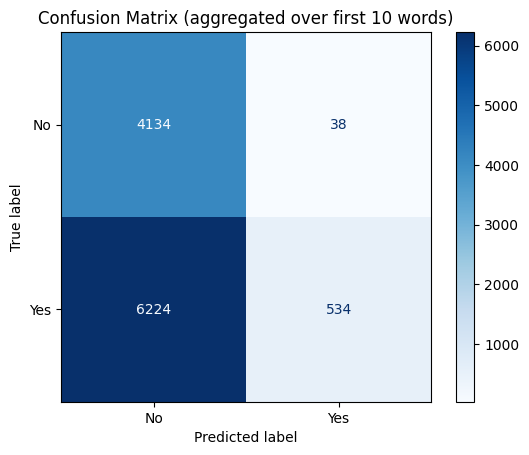

Saved test predictions -> results_nb_test.json
Saved test metrics -> eval_nb_test.csv


In [83]:
# ====== TRAIN / VALIDATION / TEST EVALUATION SUMMARY ======
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

print("\n==== ACCURACY SUMMARY (Train / Validation / Test) ====")

# --- Train accuracy ---
# You already trained using X_tr, Y_tr
scores_tr = predict_scores(model, X_tr)
Y_pred_tr = topk_to_binary(scores_tr, k=decode_len)
train_acc = accuracy_score(Y_tr.ravel(), Y_pred_tr.ravel())

# --- Validation accuracy ---
valid_acc = accuracy_score(Y_true.ravel(), Y_pred.ravel())

# --- Test accuracy ---
scores_te = predict_scores(model, X_te)
Y_pred_test = topk_to_binary(scores_te, k=decode_len)
test_acc = accuracy_score(Y_te.ravel(), Y_pred_test.ravel())

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {valid_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


# ====== TEST OUTPUT & METRICS ======
print("\n==== EVALUATION (Test Set) ====")

# Compute top-k and example-based metrics
def example_based_accuracy(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=1)
    union = np.sum((y_true + y_pred) > 0, axis=1)
    valid = union > 0
    return np.mean(intersection[valid] / union[valid]) if np.any(valid) else 0.0

topk_acc_test = topk_image_accuracy(scores_te, Y_te, k=decode_len)
example_acc_test = example_based_accuracy(Y_te, Y_pred_test)

prec_test = precision_score(Y_te.ravel(), Y_pred_test.ravel(), zero_division=0)
rec_test  = recall_score(Y_te.ravel(), Y_pred_test.ravel(), zero_division=0)
f1_test   = f1_score(Y_te.ravel(), Y_pred_test.ravel(), zero_division=0)

print(f"Top-{decode_len} Image Accuracy (Test): {topk_acc_test:.4f}")
print(f"Example-based Accuracy (Test): {example_acc_test:.4f}")
print(f"Precision: {prec_test:.4f}  Recall: {rec_test:.4f}  F1: {f1_test:.4f}")


# ====== CONFUSION MATRIX (Aggregated on Top Words) ======
num_labels_to_show = min(10, V)  # show first 10 frequent words
cm_labels = [i2w[i] for i in range(num_labels_to_show)]

cm_true = Y_te[:, :num_labels_to_show].ravel()
cm_pred = Y_pred_test[:, :num_labels_to_show].ravel()

cm = confusion_matrix(cm_true, cm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix (aggregated over first 10 words)")
plt.show()


# ====== SAVE TEST RESULTS ======
# Save predictions for reference
pred_caps_test = decode_from_scores(scores_te, k=decode_len)
with open("results_nb_test.json", "w") as f:
    json.dump({nm: cap for nm, cap in zip(names_te, pred_caps_test)}, f, indent=2)
print("Saved test predictions -> results_nb_test.json")

# Save numeric metrics
with open("eval_nb_test.csv", "w", newline="") as f:
    wr = csv.writer(f)
    wr.writerow(["model","vocab","decode_len","TrainAcc","ValAcc","TestAcc",
                 "TopK_Acc","Example_Acc","Precision","Recall","F1"])
    wr.writerow(["nb", V, decode_len, train_acc, valid_acc, test_acc,
                 topk_acc_test, example_acc_test, prec_test, rec_test, f1_test])
print("Saved test metrics -> eval_nb_test.csv")


In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def example_based_accuracy(y_true, y_pred):
    """Compute average per-image overlap accuracy (Jaccard-like)."""
    intersection = np.sum(y_true * y_pred, axis=1)
    union = np.sum((y_true + y_pred) > 0, axis=1)
    valid = union > 0
    if np.any(valid):
        return np.mean(intersection[valid] / union[valid])
    else:
        return 0.0


def topk_image_accuracy(scores, y_true, k):
    """Compute top-k image accuracy (at least one correct label in top-k)."""
    correct = 0
    for i in range(len(scores)):
        topk = np.argsort(-scores[i])[:k]
        true_indices = np.where(y_true[i] == 1)[0]
        if len(set(topk) & set(true_indices)) > 0:
            correct += 1
    return correct / len(scores)


def calculate_detailed_metrics(y_true, y_pred, scores, k, model_name="Model"):
    # ---- Top-k & example-based accuracy ----
    topk_acc = topk_image_accuracy(scores, y_true, k)
    ex_acc = example_based_accuracy(y_true, y_pred)

    # ---- Label-wise metrics ----
    precision_macro = precision_score(y_true.ravel(), y_pred.ravel(), average='macro', zero_division=0)
    recall_macro    = recall_score(y_true.ravel(), y_pred.ravel(), average='macro', zero_division=0)
    f1_macro        = f1_score(y_true.ravel(), y_pred.ravel(), average='macro', zero_division=0)

    precision_weighted = precision_score(y_true.ravel(), y_pred.ravel(), average='weighted', zero_division=0)
    recall_weighted    = recall_score(y_true.ravel(), y_pred.ravel(), average='weighted', zero_division=0)
    f1_weighted        = f1_score(y_true.ravel(), y_pred.ravel(), average='weighted', zero_division=0)

    # ---- Print results ----
    print(f"\n=== {model_name} Evaluation Metrics ===")
    print(f"Top-{k} Image Accuracy: {topk_acc:.4f}")
    print(f"Example-based Accuracy: {ex_acc:.4f}\n")
    print("Macro Average:")
    print(f" Precision: {precision_macro:.4f}")
    print(f" Recall:    {recall_macro:.4f}")
    print(f" F1-Score:  {f1_macro:.4f}\n")
    print("Weighted Average:")
    print(f" Precision: {precision_weighted:.4f}")
    print(f" Recall:    {recall_weighted:.4f}")
    print(f" F1-Score:  {f1_weighted:.4f}")


# ====== ✅ Your actual call (no need to modify anything below) ======
calculate_detailed_metrics(
    Y_true,
    Y_pred,
    scores_va,
    decode_len,
    "Naive Bayes Top-k Model"
)



=== Naive Bayes Top-k Model Evaluation Metrics ===
Top-6 Image Accuracy: 0.6755
Example-based Accuracy: 0.0501

Macro Average:
 Precision: 0.5627
 Recall:    0.5245
 F1-Score:  0.5322

Weighted Average:
 Precision: 0.9310
 Recall:    0.9505
 F1-Score:  0.9397
